In [14]:
import os
from pathlib import Path

import cv2 as cv
import matplotlib
import numpy as np
import torch
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from segment_anything import SamPredictor, sam_model_registry

from utils.processor import ImageEdge

load_dotenv()
matplotlib.use('module://matplotlib_inline.backend_inline')

# %matplotlib inline



In [15]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white',
               linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))


In [16]:
data_dir = Path(os.getenv('DATASET_DIR')) / 'phase-2'
data_dir


PosixPath('/Users/lucyxu/PycharmProjects/datasets/phase-2')

In [17]:
plt.gray()

image_paths = list(data_dir.glob('00008026.jpg'))
# image_paths = list(data_dir.glob('00006145.jpg'))
# image_paths = list(data_dir.glob('*.jpg'))
image_paths[0].name


'00008026.jpg'

<Figure size 432x288 with 0 Axes>

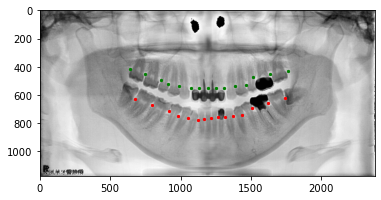

In [18]:
image_edge = ImageEdge(image_paths[0])
image_edge.plot_template_points()


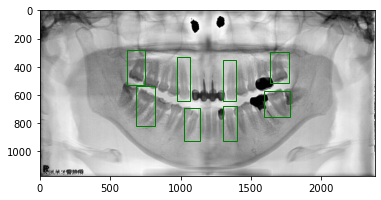

In [19]:
import matplotlib.patches as patches

boxes = np.array([i['xyxy'] for i in image_edge.split_teeth.values()])

box = boxes[0]

fig1 = plt.figure()
ax = plt.gca()
ax.imshow(1 - image_edge.im_global)
for box in boxes:
    w = box[2] - box[0]
    h = box[3] - box[1]
    patch = patches.Rectangle(box[:2], w, h, fill=False, color='green')
    ax.add_patch(patch)

plt.show()


In [20]:
sam = sam_model_registry["vit_b"](checkpoint="../../Weights/sam_vit_b_01ec64.pth")
# sam = sam_model_registry["vit_h"](checkpoint="../../Weights/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)

im = cv.cvtColor(image_edge.im_global, cv.COLOR_GRAY2RGB)

predictor.set_image(im)


<ipython-input-8-3059c3d7edb9>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  input_boxes = torch.tensor([i['xyxy'] for i in image_edge.split_teeth.values()], device=predictor.device)


<Figure size 1000x1000 with 1 Axes>

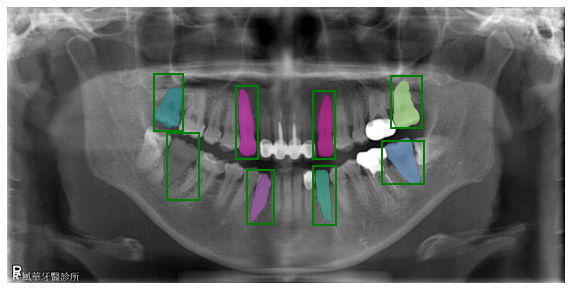

In [21]:
input_boxes = torch.tensor([i['xyxy'] for i in image_edge.split_teeth.values()], device=predictor.device)
transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, im.shape[:2])

masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(im)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()


<Figure size 640x480 with 1 Axes>

dict_keys(['flag', 'tooth_position', 'org_file_name', 'offset', 'padding', 'image', 'xyxy', 'image_rotated', 'angle', 'jaw_pos_rotated', 'gaps_rotated'])

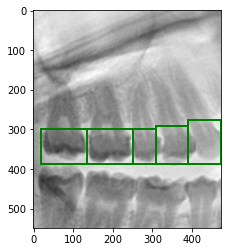

dict_keys(['flag', 'tooth_position', 'org_file_name', 'offset', 'padding', 'image', 'xyxy', 'image_rotated', 'angle', 'jaw_pos_rotated', 'gaps_rotated'])

In [22]:
a = image_edge.teeth_roi_images
b = a[0]
c = b['gaps_rotated']
jaw_pos = b['jaw_pos_rotated']

boxes = []
for i in range(len(c) - 1):
    x1 = c[i][0]
    x2 = c[i + 1][0]
    y2 = jaw_pos

    crown_size = max(y2 - c[i][1], y2 - c[i + 1][1])
    y1 = y2 - (crown_size / 2 * 5)
    y1 = y2 - crown_size

    box = np.array([x1, y1, x2, y2])
    boxes.append(box)

plt.imshow(1 - b['image_rotated'])
# for i in d:
#     plt.scatter(*i, s=5, color='green')
for i in boxes:
    show_box(i, plt.gca())
plt.show()

b.keys()


In [23]:
im_roi_rotated = b['image_rotated']
im_roi_rotated = cv.cvtColor(im_roi_rotated, cv.COLOR_GRAY2RGB)

predictor.set_image(im_roi_rotated)


<Figure size 640x480 with 1 Axes>

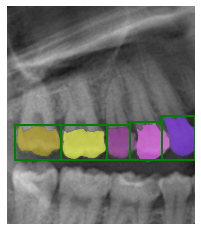

In [24]:
input_boxes = torch.tensor(boxes, device=predictor.device)

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, im_roi_rotated.shape[:2])
masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

# plt.figure(figsize=(10, 10))
plt.imshow(im_roi_rotated)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
for box in input_boxes:
    show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()


<Figure size 640x480 with 1 Axes>

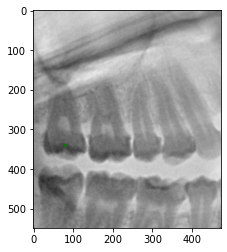

In [25]:
# a = np.array([[True, False, True],
#               [True, True, True],
#               [False, True, False]])

mask = masks[0].clone().squeeze()

b = np.where(mask)

mask_points = np.array([[j, i] for i, j in zip(*b)])

p = [np.median(mask_points[:,0]), np.median(mask_points[:,1])]

plt.imshow(1 - im_roi_rotated)
# for p in mask_points[:100]:
#     plt.scatter(*p, color='green', s=5)
plt.scatter(*p, color='green', s=5)
plt.show()



<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

<Figure size 1000x1000 with 1 Axes>

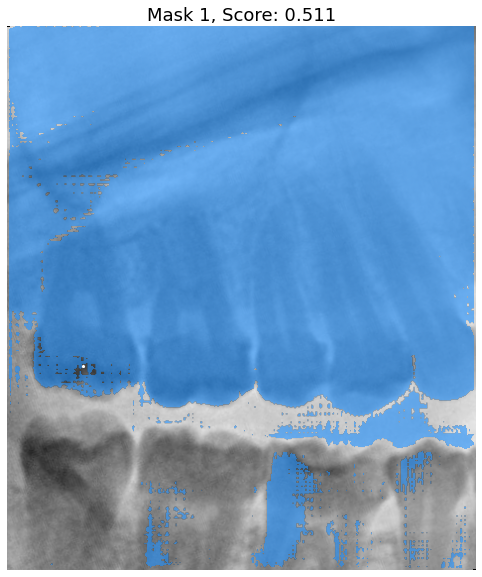

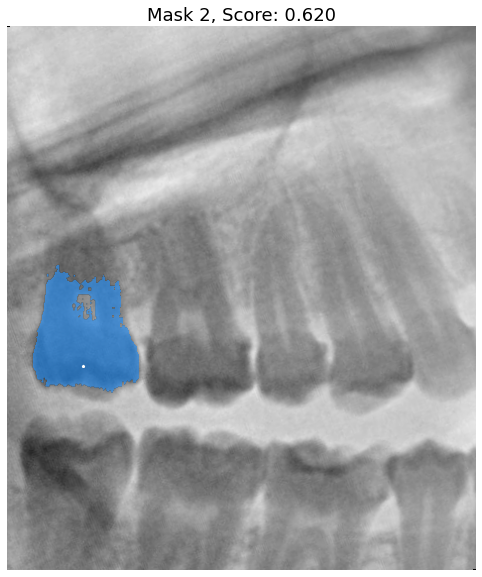

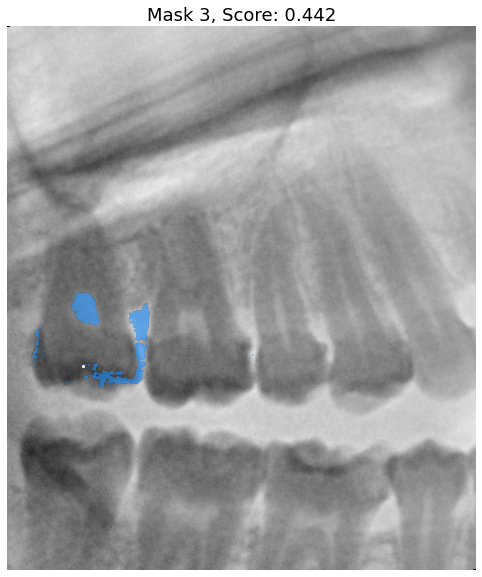

In [26]:
idx = 1
# input_point = np.array([d[idx]])
x1, y1, x2, y2 = boxes[0]
input_point = np.array([[(x1 + x2) / 2, (y1 + y2) / 2]])
input_label = np.array([0])

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10, 10))
    plt.imshow(1 - im_roi_rotated)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca(), marker_size=5)
    plt.title(f"Mask {i + 1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()
